In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

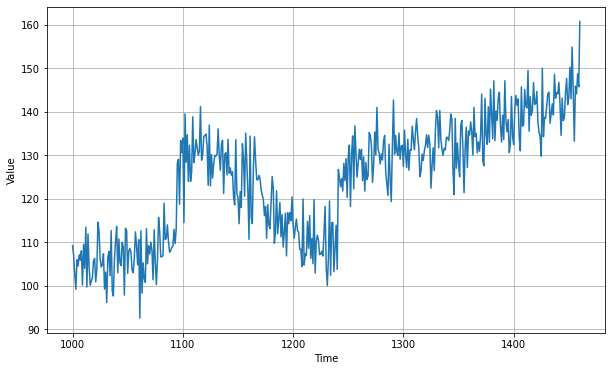

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


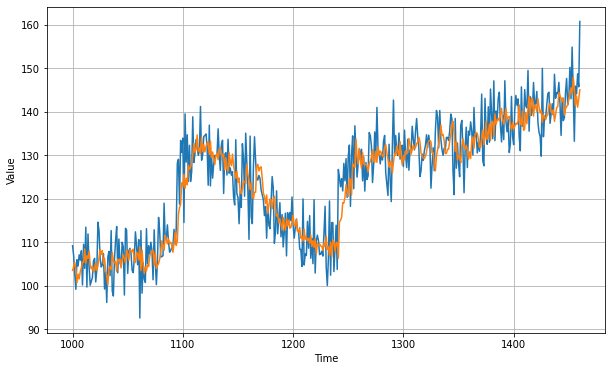

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6216445

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

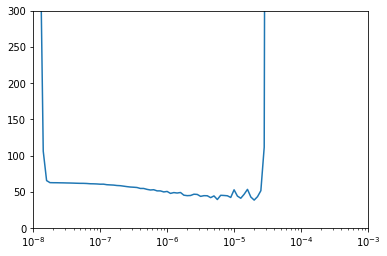

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

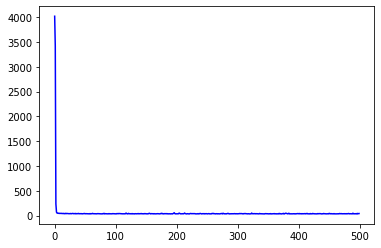

In [13]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[44.0974006652832, 43.611534118652344, 39.95233154296875, 41.667232513427734, 39.10081481933594, 43.05994415283203, 37.07868576049805, 38.28973388671875, 43.69637680053711, 37.96371841430664, 41.68752670288086, 39.72441482543945, 39.994285583496094, 37.397193908691406, 37.72167205810547, 37.38961410522461, 40.716312408447266, 36.0136604309082, 38.999176025390625, 41.118221282958984, 41.428070068359375, 36.76637268066406, 38.42066955566406, 37.505165100097656, 41.6983642578125, 33.99870681762695, 38.61793518066406, 37.54470443725586, 37.434906005859375, 42.253150939941406, 36.5184211730957, 36.98984909057617, 35.24071502685547, 37.606746673583984, 37.486427307128906, 34.05064010620117, 35.91610336303711, 38.162353515625, 41.667198181152344, 40.79203796386719, 35.3491096496582, 37.53075408935547, 37.00886535644531, 36.27446746826172, 35.62076187133789, 35.10358428955078, 36.121910095214844, 33.98918914794922, 39.45372009277344, 33.66221618652344, 34.653770446777344, 37.7482795715332, 43.

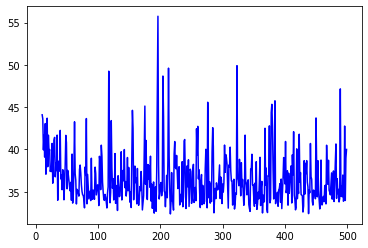

In [14]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

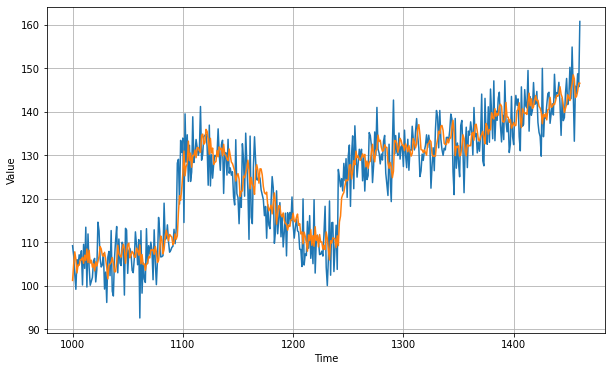

In [15]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5832133